In [586]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [587]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 16})

In [588]:
import os
import psycopg2 as pg

conn = pg.connect(
    host=os.getenv('DATA_HOST'), 
    port=os.getenv('DATA_PORT'), 
    database=os.getenv('DATA_DB_NAME'), 
    user=os.getenv('DATA_DB_USER'), 
    password=os.getenv('DATA_DB_PASS'),
)
# Reading data from CSV
# df = pd.read_csv('realestate.csv')
# From a database
df = pd.read_sql('SELECT * from realestate', conn)

So, this is not a comprehensive explanation of these tools, but rather a quick overview of some simple samples which allow you to leverage some basic funcionalities & explore the data.

Loading data can be done from multiple sources. I used my database for the raw scraped data, on which I'm doing the analysis.

In [589]:
df.drop('source_website', 1, inplace=True)

In [590]:
df.shape

(12767, 18)

In [591]:
df.head()

,fingerprint,title,description,posted_date,price,currency,partitioning,surface,building_year,floor,number_of_rooms,terrace,parking,cellar,source_offer,neighborhood,link,scraped_date
0,74e17d23a02495e3b88bf44092cb1db038746db2,"inchiriere studio, centru",capital imobiliare va propune spre inchiriere un studio situat in ...,2019-09-27 15:54:54.472305,600,EUR,semidecomandat,30.0,1970,1.0,1.0,False,False,False,companie,central,https://lajumate.ro/inchiriere-studio-centru-10668359.html,2019-09-27 16:00:54.451592
1,9a31af8d7611751bf4ce6bab9f2578e50af4134e,Apartament 3 camere mobilat utilat Mihai Viteazu,Descriere anunt.css-k7cvuo{line-height:25px;display:block;position...,2019-08-20 12:21:20.515434,350,EUR,decomandat,70.0,2007,5.0,3.0,False,True,False,,viteazu,https://www.storia.ro/oferta/apartament-3-camere-mobilat-utilat-mi...,NaT
2,08ae8b49015d9782a775020623dba1866ac9f084,Apartament 2 camere zona calea dumbravi,Descriere anunt.css-k7cvuo{line-height:25px;display:block;position...,2019-08-20 12:21:29.130445,300,EUR,decomandat,56.0,None,1.0,2.0,False,False,False,,not found,https://www.storia.ro/oferta/apartament-2-camere-zona-calea-dumbra...,NaT
3,bce74cfea30ae809f888cc5cb8066874a68c410d,"Apartament 2 camere, 70 mp, semidecomandat, zona Ultracentrala",Descriere anunt.css-k7cvuo{line-height:25px;display:block;position...,2019-08-28 22:04:16.964435,550,EUR,None,70.0,None,1.0,2.0,False,False,False,,ultracentral,https://www.storia.ro/oferta/apartament-2-camere-70-mp-semidecoman...,NaT
4,366d9a05e81ed608918ee65f52fe9efb49758dd5,inchiriez ap 2 camera 48m mp in cartierul manastur,inchiriez ap cu 1 camera cu living si bucatarie baie camara la cas...,2019-09-23 17:02:11.452970,350,EUR,nedecomandat,48.0,None,NaN,1.0,False,False,False,proprietar,manastur,https://www.storia.ro/oferta/inchiriez-ap-2-camera-48m-mp-in-carti...,2019-09-23 16:02:11.447050


Next up, you want to take a look at the data, get a feel of the fields you are working with. Shape gives you the number of rows and column, and head gives you the first 5 items in the dataset, so a small preview.

In [592]:
df['title'] = df['title'].str.lower()

# Some description were badly scraped and contain css formatting
# This corrects that
mask = df.description.str.contains('css', case=False)
df.loc[mask, 'description'] = df.loc[mask, 'description'].apply(lambda p: (p.split('}')[9]).split('.css-1prr4ql')[0])

df['description'] = df['description'].str.lower()

In [593]:
# Uneeded for analysis
df = df.drop('fingerprint', 1)
df.drop('link', 1, inplace=True)
df.drop('scraped_date', 1, inplace=True)

In [594]:
# More unneeded observations
df.drop('building_year', 1, inplace=True)
df.drop('partitioning', 1, inplace=True)

In [595]:
# Updating column name
df.rename(columns={'number_of_rooms': 'rooms'}, inplace=True)

You might have uneeded obervations, that can be safely removed. Like I previously said, these fields make sense to other processes, not so much when you're doing data analysis. You have 2 ways of doing operations on dataframes, exemplified with drop: perform the action, and reasign to another variable (or itself), or use the inplace=True argument. Also, I renamed a column for ease of use.

In [596]:
# Dropping rows that don't have a posting date
df = df.dropna(subset=['posted_date'])

In [597]:
# Nullify missing values
df.source_offer = df.source_offer.replace({
    '': None
})

In [598]:
df['source_offer'].isna().sum()

2173

In [599]:
df['source_offer'] = df['source_offer'].fillna('unknown')

When handling rows with missing data, it's not generally recommended to just drop data, but to actually flag it as missing, but since we're relying on the posting date, we need to eliminate ads that don't have one.
Conversely, for other fields we can go that route. For example the source of an offer has quite a sizable amount of nulls. Let's mark them as unknow.

In [600]:
df.groupby('currency').size()

currency
EUR    12452
RON      209
dtype: int64

In [601]:
sort_df = df.sort_values(by='posted_date')
print(sort_df.head(1)['posted_date'])
print(sort_df.tail(1)['posted_date'])

6126   2018-06-12
Name: posted_date, dtype: datetime64[ns]
5801   2019-12-09
Name: posted_date, dtype: datetime64[ns]


In [602]:
# Average currency value from the earliest to the latest result
avg_eur_to_ron = 4.732

# Apply the conversion only to rows with RON currency
mask = df['currency'] == 'RON'
df.loc[mask, 'price'] = df.loc[mask, 'price'].apply(
    lambda p: p / avg_eur_to_ron
)

# Currency is all the same now, so it's an irrelevant observation
df.drop('currency', 1, inplace=True)

It appears we have 2 currencies! But EUR is still used in the majority of the ads, so I'm going to convert them all to EUR. I'm taking a peek at the earliset ad & the latest one and getting an average conversion, then I'm performing it in place. Now that we have only 1 currency, we can drop the currency field.

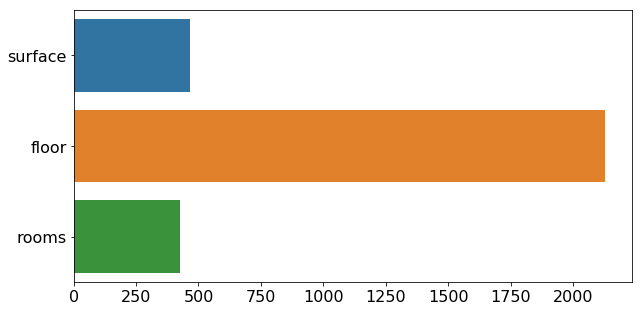

In [603]:
# Number of null values per column
df_nulls = df.isnull().sum()
df_nulls = df_nulls[df_nulls > 0]
nulls_graph = sb.barplot(x=df_nulls.values, y=df_nulls.index)

In [604]:
df['posted_date_month'] = df['posted_date'].dt.strftime('%m')
df['posted_date_month'] = pd.to_numeric(df['posted_date_month'], errors='coerce')
df = df.loc[df.posted_date_month < 10]
df = df.loc[df.posted_date_month > 3]
df['posted_date'] = df['posted_date'].map(lambda d: str(d).split(' ')[0])

In [605]:
pd.DataFrame(df.groupby('source_offer').size(), columns=['count'])

,count
source_offer,
Agentie,28
Proprietar,30
agentie,5009
agentie imobiliara,1306
companie,360
constructor,4
persoana fizica,599
persoană fizică,19
proprietar,3025


In [606]:
df['source_offer'] = df['source_offer'].str.lower()
df.source_offer = df.source_offer.replace({
    'agentie': 'real estate agency',
    'companie': 'real estate agency',
    'constructor': 'building company',
    'persoana fizica': 'owner',
    'persoană fizică': 'owner',
    'proprietar': 'owner',
    'agentie imobiliara': 'real estate agency'
})

In [607]:
pd.DataFrame(df.groupby('source_offer').size(), columns=['count'])

,count
source_offer,
building company,4
owner,3673
real estate agency,6703
unknown,2173


Next, would be uniformization. The capitalization might be incosistent or 2 things that actually mean the same thing are expressed differently (both of which happen above). Sometimes there might be typos. For this a mapping can be provided to replace the values. Running it again, and it looks way better!

In [608]:
df.groupby('neighborhood').size()

neighborhood
? string:18 ?             1
andrei muresanu         279
aurel vlaicu              3
baciu                    67
becas                     1
borhanci                 54
bulgaria                 15
buna ziua               664
calea turzii            186
campului                 27
central                  89
centru                  971
dambul rotund            46
dorobantilor            159
est                       1
europa                  143
expo transilvania        19
faget                     2
floresti                155
gara                    828
gheorgheni              920
grigorescu              369
gruia                    52
hasdeu                   33
horea                    79
interservisan            36
intre lacuri            180
iris                    153
iulius                  640
manastur               1148
marasti                1129
muzeului                 17
not found              1665
p-ta mihai viteazul      20
piata unirii             47
plopilo

In [609]:
mapping = {
    'calea turzii': 'andrei muresanu',
    'sigma': 'zorilor',
    'cipariu':'centru',
    'motilor':'centru', 
    'muzeului':'centru', 
    'piata unirii':'centru', 
    'viteazu': 'centru', 
    'ultracentral': 'centru',
    'the office': 'marasti',
    'usamv': 'manastur',
    'polus': 'vivo',
    'interservisan': 'gheorgheni', 
    'titulescu': 'gheorgheni', 
    'iulius': 'gheorgheni',
    'expo transilvania':'intre lacuri',
    'semicentral': 'centru',
    'aurel vlaicu': 'marasti',
    'dorobantilor': 'marasti',
    'central': 'centru',
    'vest': 'floresti',
    'est': 'someseni',
    'campului': 'manastur',
    'gara': 'centru',
    'horea': 'centru',
    'hasdeu': 'centru',
    'p-ta mihai viteazul': 'centru',
    'vivo': 'floresti',
}
df.neighborhood = df.neighborhood.replace(mapping)
df = df.loc[df.neighborhood != '? string:18 ?']

In [610]:
df['price_sqm'] = df['price'] / df['surface']

New fields can also be added. For example, I wanted the price per sqm to be a column as well.

In [611]:
df.floor = df.floor.astype(str)
df.floor = df.floor.map(lambda d: str(d).split('.')[0])
df.floor = df.floor.replace({'99': 'attic', '0': 'ground floor', '-1': 'basement'})

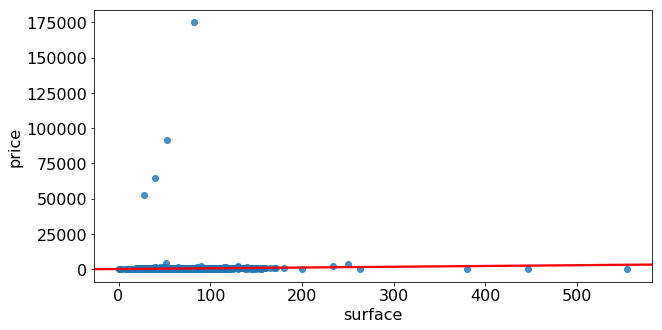

In [612]:
# Exploring the linear relationship between price and surface
def lin_graph(dataframe, x, y):
    kwargs = {'line_kws': {'color':'red'}}
    return sns.regplot(x=x, y=y, data=dataframe, **kwargs)

g = lin_graph(df, "surface", "price")

Then, we should identify outliers. I'm going to explore some linear relations to identify them. 
There are definitely outliers. Let's check them out.
These can be brought on by sellers wrongly marking apartments for sale as for rent
or other types of ads such as renting per night, dorms, office spaces, 
which are not residential and skew the results. Also people only renting out 1 rooms from 4.
After some additional cleaning, the graph looks like this

In [613]:
df.loc[df.price > 25000]

,title,description,posted_date,price,surface,floor,rooms,terrace,parking,cellar,source_offer,neighborhood,posted_date_month,price_sqm
5315,"apartament 3 camere, centru, ultracentral, zona strazii memorandum...",residence imobiliare va ofera spre vanzare un apartament situat in...,2019-08-30,175000.0,82.0,1,3.0,False,False,False,unknown,centru,8,2134.146341
5887,"apartament 2 camere, centru/gara","apartament 2 camere in zona centrala, demisol, 40 mp2, living, buc...",2019-09-08,65000.0,40.0,basement,2.0,False,False,True,owner,centru,9,1625.000000
7444,"2 camere, finisat, mobilat ,in bloc nou, 53 mp, zona piata 1 mai","local imobiliare ofera spre inchiriere un apartament cu 2 camere,...",2019-09-11,91900.0,53.0,7,2.0,True,False,False,real estate agency,not found,9,1733.962264
9213,"vanzare garsoniera confort 1, zona casa piratilor, manastur",descriere anuntcapital imobiliare va propune spre vanzare o garson...,2019-08-07,53000.0,28.0,nan,1.0,True,False,False,real estate agency,manastur,8,1892.857143


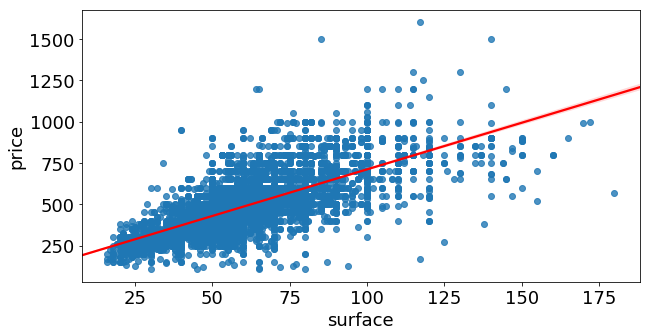

In [639]:
g = lin_graph(df, "surface", "price")

In [615]:
# Outliers can be brought on by sellers 
# wrongly marking apartments for sale as for rent
# Or just general mislabeling and  extreme values
df = df.loc[df.price > 100]
df = df.loc[df.price < 2000]
df = df.loc[df.surface < 200]
df = df.loc[df.surface > 15]
df = df.loc[df.price_sqm < 25]

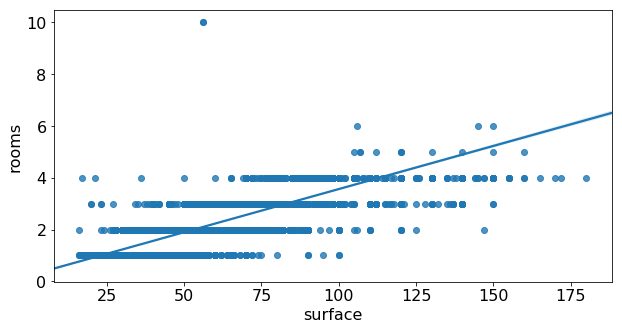

In [616]:
# Exploring the linear relationship between surface and rooms
linear_graph = sb.regplot(x="surface", y="rooms", data=df)

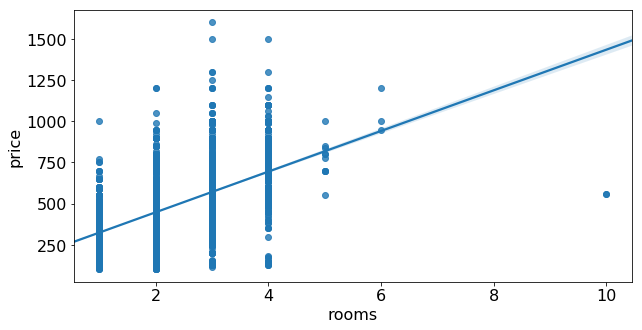

In [617]:
# Exploring the linear relationship between price and rooms
linear_graph = sb.regplot(x="rooms", y="price", data=df)

In [618]:
# Deleting office spaces, dorm, single rooms offerings
# since I'm only interested in full residential rooms
df = df.loc[df.title.str.contains('camera', case=False) == False]
df = df.loc[df.title.str.contains('camin', case=False) == False]
df = df.loc[df.title.str.contains(' ron', case=False) == False]
df = df.loc[df.title.str.contains('caut', case=False) == False]
df = df.loc[df.title.str.contains('birou', case=False) == False]

In [619]:
# Remove less than 10, not very helpful for statistics
df = df.groupby('neighborhood').filter(lambda x: len(x)>9)

In [620]:
# Writing data to CSV
df.to_csv('cleaned_data.csv', index=False)

Now that our data is cleaned, we can save it to a csv and we can start getting some stats out of it!

In [621]:
plt.rcParams.update({'font.size': 18})

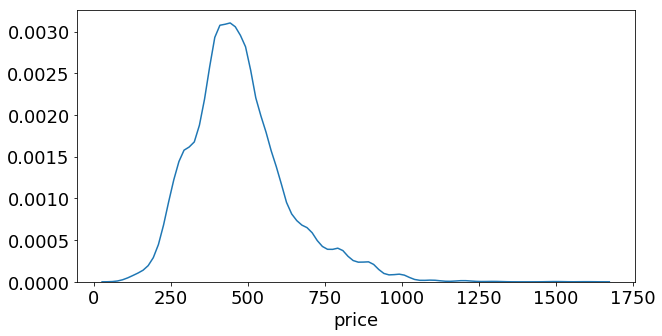

In [623]:
# Let's check out the price distribution
price_distrib_plot = sb.distplot(df["price"], hist=False);

In [624]:
# Monthly average
df_avg_month_grouped = df.groupby('posted_date_month').mean()['price']
pd.DataFrame(df_avg_month_grouped)

,price
posted_date_month,
4,399.985110
5,397.397681
6,423.202114
7,481.050864
8,474.589710
9,490.299552


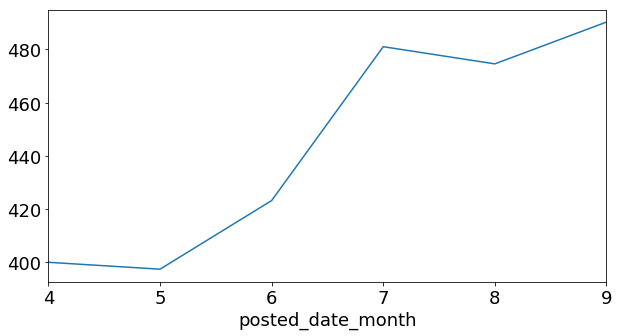

In [625]:
avg_price_month_plot = df_avg_month_grouped.plot()

In [643]:
# Average prices for top 3 most expensive, least expensive
avg_price_areas = df.groupby('neighborhood')['price'].mean().sort_values(ascending=False)

In [646]:
top3_df = pd.DataFrame(top3)

# Formatting for visibility :)
style = top3_df.style
style.set_properties(**{'font-size':'16pt'})

,price
neighborhood,
plopilor,549.82
centru,530.676
borhanci,523.327


In [649]:
bottom3_df = pd.DataFrame(bottom3)

# Formatting for visibility :)
style = bottom3_df.style
style.set_properties(**{'font-size':'16pt'})

,price
neighborhood,
baciu,341.214
floresti,307.65
gruia,298.941


In [629]:
df.floor = df.floor.replace({'nan': 'unknown'})
df = df.loc[df.neighborhood != 'not found']

In [630]:
def get_field_count_mapping(dataframe, field, title=None, limit=0):
    sizes = list(
        dataframe.groupby(field).count().sort_values(by=field)['title']
    )
    labels = sorted(dataframe[field].unique())
    sizes, labels = list(zip(*sorted(zip(sizes, labels))))
    sizes, labels = sizes[::-1], labels[::-1]
    if limit > 0:
        sizes, labels = sizes[:limit] + (sum(map(lambda x: int(x),sizes[limit:])), ), labels[:limit] + ('others', )

    return sizes, labels

def build_piechart(data, field, limit=0, title=None):
    sizes, labels = get_field_count_mapping(data, field, limit=limit)
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(0.3, 0, 1, 1)
    ax.pie(sizes, startangle=90)
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=[
            '%s, %.2f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, sizes)
        ],
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig.transFigure
    )
    if title:
        plt.xlabel(title)
    return plt

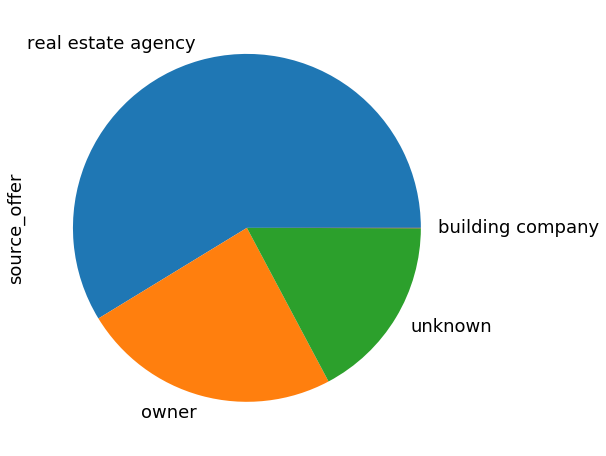

In [631]:
df_partial = df['source_offer'].value_counts()[:5]
chart = df_partial.plot.pie(figsize=(8, 8))

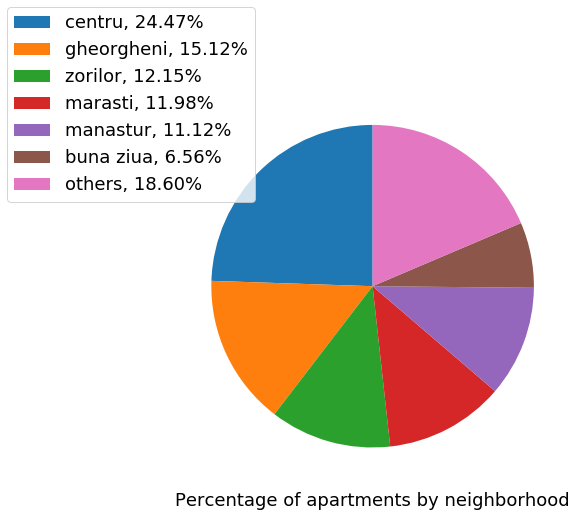

In [632]:
neighborhood_chart = build_piechart(df, 'neighborhood', 6, 'Percentage of apartments by neighborhood')

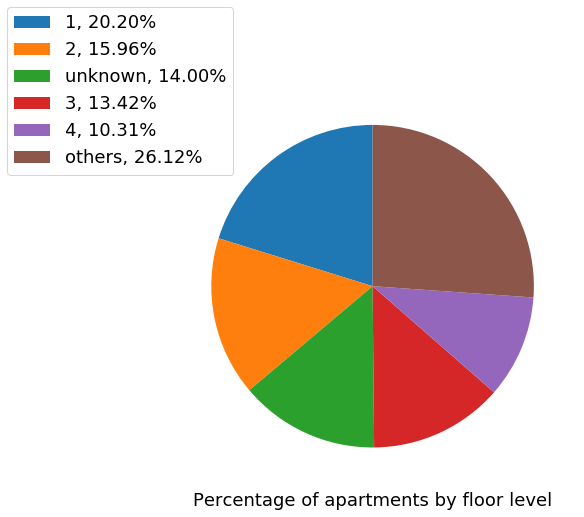

In [633]:
floors_chart = build_piechart(df, 'floor', 5, 'Percentage of apartments by floor level')

In [634]:
yesno_map = {True: 'Yes', False: 'No'}
yesno_map_color = {'Yes': 'orange', 'No': 'purple'}

def build_piechart(data, field, title):
    sizes, labels = get_field_count_mapping(data, field)
    labels = [yesno_map.get(mapped_bool) for mapped_bool in labels]
    
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    fig1.subplots_adjust(0.3, 0, 1, 1)
    _, _ = ax1.pie(sizes, startangle=90, colors=[yesno_map_color.get(lbl) for lbl in labels])
    ax1.axis('equal')
    total = sum(sizes)
    plt.legend(
        loc='upper left',
        labels=['%s, %.2f%%' % (l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
        bbox_to_anchor=(0.0, 1),
        bbox_transform=fig1.transFigure,
    )
    plt.xlabel(title)
    return plt

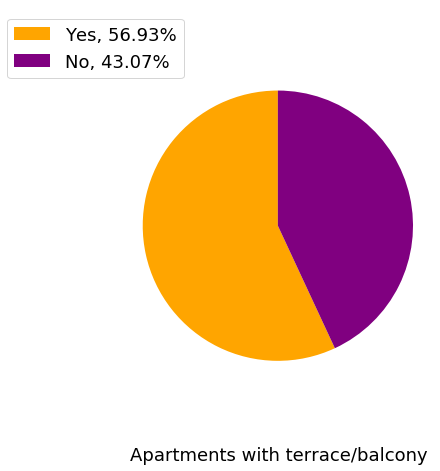

In [635]:
chart_terrace = build_piechart(df, 'terrace', title="Apartments with terrace/balcony")

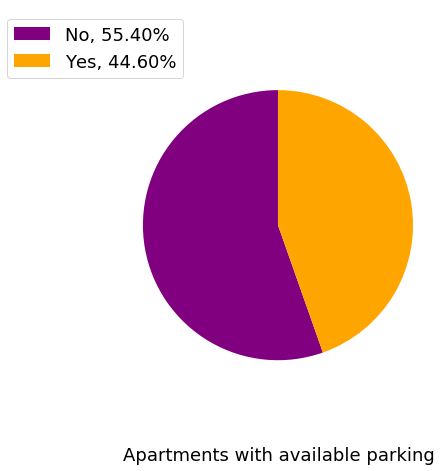

In [636]:
chart_parking = build_piechart_yesno(df, 'parking', title="Apartments with available parking")

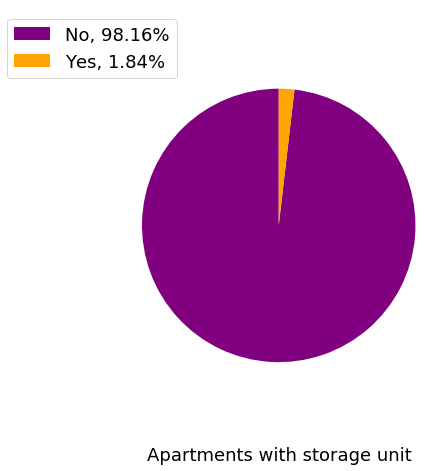

In [637]:
chart_storage = build_piechart(df, 'cellar', title="Apartments with storage unit")

<a href="https://danielacraciun.github.io/apartment-hunter/#jump-back">Return to presentation</a>

Now, let's starting looking for apartments! This is automated, too.

In [673]:
my_ap = data = [[420, 65, 420 / 65, 3, "gheorgheni", "owner"]]
my_ap_df = pd.DataFrame(data, columns=["price", "surface", "price_sqm", "rooms", "neighborhood", "source"])

# Formatting for visibility :)
style = my_ap_df.style
style.hide_index()
style.set_properties(**{'font-size':'14pt'})

price,surface,price_sqm,rooms,neighborhood
420,65,6.46154,3,gheorgheni


So, stats: the apartment found: 3 rooms, 450 (more like 420-ish after discussing the price), 65 sqm surface, gheorgheni neighborhood

So, how does it compare to the total price, surface & price_sqm average?
What about 3 rooms apartments?
What about 3 rooms apartment in the same neighborhood?
How many other deals similar to this?

Rare, fair priced bargain!
Slightly under performing in the surface area, but otherwise quite a good deal!

In [663]:
cols = ["Average price", "Average price/sqm", "Average surface"]
data = [[df['price'].mean(), df['price_sqm'].mean(), df['surface'].mean()]]
df_avg = pd.DataFrame(data, columns=cols)

# Formatting for visibility :)
style = df_avg.style
style.hide_index()
style.set_properties(**{'font-size':'18pt'})

Average price,Average price/sqm,Average surface
479.233,8.41732,58.9284


In [695]:
df_3rooms_myarea = df[(df['rooms']==3) & (df['neighborhood']=='gheorgheni')]

data = [
    [df_3rooms_myarea['price'].mean(), 
     df_3rooms_myarea['price_sqm'].mean(), 
     df_3rooms_myarea['surface'].mean()]
]
df_avg = pd.DataFrame(data, columns=cols)

# Formatting for visibility :)
style = df_avg.style
style.hide_index()
style.set_properties(**{'font-size':'18pt'})

Average price,Average price/sqm,Average surface
581.628,8.23947,71.219


In [714]:
# How many other apartments like this one?
df_similar_ap = df_3rooms_myarea[
    (df_3rooms_myarea['price']<=450) & 
    (df_3rooms_myarea['surface']>60) & 
    (df_3rooms_myarea['surface']<70) & 
    (df_3rooms_myarea['source_offer']=="owner")
]
percentage = (df_similar_ap.shape[0] - 1)/df.shape[0] * 100
print(f"There's other {percentage:.3f}% similar apartments")

There's other 0.055% similar apartments


<a href="https://danielacraciun.github.io/apartment-hunter/#the-end">Return to presentation</a>